In [1]:
import math
from numpy import sin, cos, exp, pi
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# численное интегрирование по промежутку [a, b]
def integrator(function, a, b):
    step = 0.001
    t = np.linspace(a, b, int((b - a) / step))
    return sum([function(i) * step for i in t])

In [3]:
# вспомогательная функция для обнуления значений меньше допустимой погрешности
def fitter(array):
    for i in range(len(array)):
        if abs(array[i]) < math.e**(-10):
            array[i] = 0
        array[i] = round(array[i], 2)
    return array

In [4]:
# нахождение k-кого коэффициента разложения в классический ряд Фурье
def find_a_k(function, w_n, dt):
    a_func = lambda t: function(t) * cos(w_n * t)
    a_k = integrator(a_func, dt[0], dt[1])
    if abs(a_k) < math.e**(-10):
        return 0.0
    return a_k

def find_b_k(function, w_n, dt):
    b_func = lambda t: function(t) * sin(w_n * t)
    b_k = integrator(b_func, dt[0], dt[1])
    if abs(b_k) < math.e**(-10):
        return 0.0
    return b_k

In [14]:
# получение всех коэффицентов разложения в классический (по косинусам и синусам) ряд Фурье
def get_coeffs_real(function, T, dt, n):
    a_coeffs = [2 / T * find_a_k(function, 2 * pi * k/T, dt) for k in range(0, n)]
    # a_coeffs[0] /= 2
    b_coeffs = [2 / T * find_b_k(function, 2 * pi * k/T, dt) for k in range(0, n)]
    a_coeffs = fitter(a_coeffs)
    b_coeffs = fitter(b_coeffs)
    return a_coeffs, b_coeffs

In [15]:
# разложение функции в ряд Фурье по косинусам и синусам
def create_fourier_classical(function, T, dt, n):
    a_coeffs, b_coeffs = get_coeffs_real(function, T, dt, n)
    a_coeffs[0] /= 2
    approx = lambda t: sum([a_coeffs[i] * cos(2 * pi * i * t/T) + b_coeffs[i] * sin(2 * pi * i * t/T) for i in range(n)] )
    return approx

In [16]:
# проверка выполнения равенства Парсеваля для разложенной в ряд Фурье по косинусам и синусам функции
def check_Parseval_equation_real(function, T, dt, a_ks, b_ks):
    a, b = dt[0], dt[1]
    function_squared = lambda t: function(t)**2
    function_norm = 2/T * integrator(function_squared, a, b)
    coeff_norm = a_ks[0] ** 2 / 2
    for i in range(1, len(a_ks)):
        coeff_norm += (a_ks[i]**2 + b_ks[i]**2)
    return function_norm, coeff_norm


In [17]:
# Функция, сохраняющая построенные графики разложения в Фурье ряд синусам и косинусам
def save_Fn(original_function, N):
    fig, ax = plt.subplots()
    x = np.linspace(1, 10, 100)
    y_1 = [original_function(i) for i in  x]
    fourier_approx = create_fourier_classical(original_function, 4, [-2, 2], N)
    y_2 = [fourier_approx(x[i]) for i in range(len(x))]
    ax.plot(x, y_1, label='original')
    ax.plot(x, y_2, label='F_n = ' + str(N))
    ax.grid(True)
    ax.legend()
    plt.savefig('F_' + str(N) + '_classical.jpg')

In [84]:
# исходная функция, которую будем раскладывать в ряд Фурье 
def original_function(t):
    return 3 * t

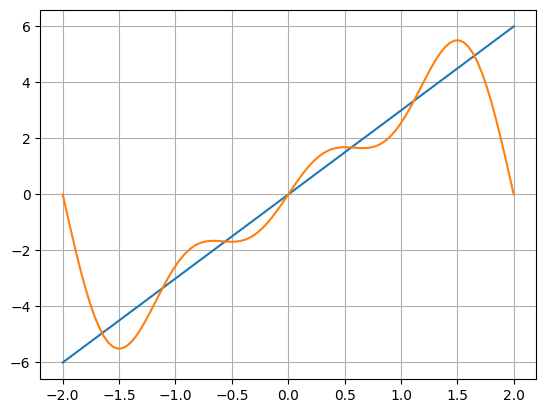

Левая и правая части равенства Парсеваля: (24.012003000750205, 19.8534)


In [85]:
T = 4 # рассматриваемый период 
dt = [-2,  2] # промежуток интегрирования 
N = 4
fig, ax = plt.subplots()
x_1 = np.linspace(dt[0], dt[1], 100)
y = [original_function(i) for i in x_1]
a_ks, b_ks = get_coeffs_real(original_function, T, dt, N)
approx = create_fourier_classical(original_function, T, dt, N)
y_approx =  [approx(p) for p in x_1]
ax.plot(x_1, y)
ax.plot(x_1, y_approx)
plt.grid(True)
plt.show()

print(f"Левая и правая части равенства Парсеваля: {check_Parseval_equation_real(original_function, T, dt, a_ks, b_ks)}")

In [86]:
# нахождение k-кого коэффициента разложения в экспоненциальный ряд Фурье
def find_c_k(function, w_n, dt):
    return 1/T * integrator(lambda t: function(t) * exp(-1j * w_n * t), dt[0], dt[1])

In [87]:
# функция для получения всех коэффициентов экспоненциального ряда Фурье

def get_c_k(function, T, dt, n):
    w_n = (2 * pi)/T
    c_coeffs_pos = [0 for i in range(0, n)] # исключительно ненулевые коэффициенты
    for i in range(0, n):
        c_i = find_c_k(function, w_n * i, dt)
        c_coeffs_pos[i] = c_i
    return c_coeffs_pos


In [88]:
# разложение функции в экспоненциальный ряд Фурье
def create_fourier_exponential(function, T, dt, n):
    c_coeffs_pos = get_c_k(function, T, dt, n)
    w_n = (2 * pi)/T
    # при составлении аппроксимации учитываем, что  c_coeffs_pos содержит только ненулевые коэффициенты ряда
    return lambda t: c_coeffs_pos[0] + sum([c_coeffs_pos[i] * exp(1j * i * w_n * t) + np.conj(c_coeffs_pos[i]) * exp(-1j * i * w_n * t) for i in range(1, n)])

In [95]:
def check_Parseval_exponential(function, T, dt, c_k):
    step = 0.00001
    a, b = dt[0], dt[1]
    t = np.linspace(a, b, int((b - a) / step))
    left_part =  1 / T * sum([function(i) * np.conjugate(function(i)) * step for i in t])
    right_part = sum([np.abs(c_k[i])**2 for i in range(len(c_k))])
    return left_part, right_part


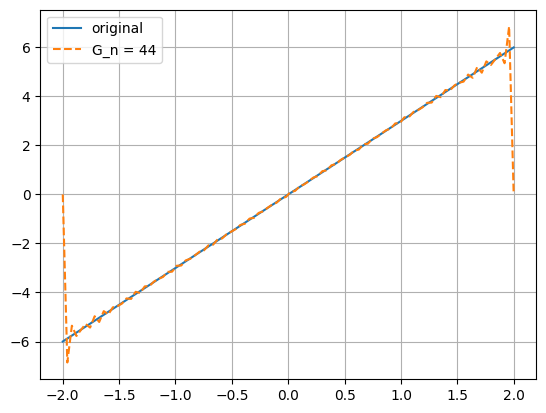

Левая и правая части равенства Парсеваля: (12.00003000015026, 11.826258949022796)


In [99]:
fig, ax = plt.subplots()
N = 44
x = np.linspace(-2, 2, 100)
y_1 = [original_function(i) for i in x_1]
fourier_approx = create_fourier_exponential(original_function, 4, [-2, 2], N)
c_ks = get_c_k(original_function, 4, [-2, 2], N)
for i in range(1, N):
    c_ks.append(np.conj(c_ks[i]))

y_2 = [np.real(fourier_approx(x_1[i])) for i in range(len(x))] # учитываем лишь вещественную часть - мнимая равна 0 для вещественных функций
ax.plot(x, y_1, label='original')
ax.plot(x, y_2, '--', label='G_n = ' + str(N))
ax.grid(True)
ax.legend()
plt.show()

print(f"Левая и правая части равенства Парсеваля: {check_Parseval_exponential(original_function, T, dt, c_ks)}")
None